# Hybrid SARIMA + LSTM Model

Time series forecasting often requires balancing between capturing **linear patterns** (trend, seasonality) and **nonlinear dynamics** (local fluctuations, sudden changes).  
- **SARIMA** (Seasonal ARIMA) is well-suited for modeling **trend and seasonality** with linear assumptions.  
- **LSTM** (Long Short-Term Memory) is a recurrent neural network capable of learning **nonlinear dependencies** and long-term temporal patterns.  

After testing both standalone models:  
- **SARIMA** provided stable forecasts but struggled with certain nonlinear fluctuations.  
- **LSTM autoregressive** captured nonlinear patterns more effectively, but may be sensitive to noise and outliers.  

The **Hybrid SARIMA + LSTM** approach combines their strengths:  
1. Use **SARIMA** to model and forecast the main trend and seasonality.  
2. Compute the **residuals** (difference between actual and SARIMA predictions).  
3. Train an **LSTM** on these residuals to capture any remaining nonlinear structure.  
4. The final hybrid forecast = **SARIMA forecast + LSTM residual forecast**.  

This design leverages SARIMA’s interpretability for seasonal/linear patterns while allowing LSTM to correct for nonlinear effects that SARIMA cannot capture.  


#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as pyoff

from pmdarima import auto_arima
import statsmodels.api as sm
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")

#### Load and preprocess data

In [2]:
df = pd.read_csv("D:\Projects\Sales_EDA_Dashboard\Data\Processed\Sales_Data_Clean.csv")

df['Order Date'] = pd.to_datetime(df['Order Date'])

# Create a new dataframe
daily_sales = df.groupby(df['Order Date'].dt.date)['Sales'].sum().reset_index()

# Rename the column
daily_sales.rename(columns={'Order Date': 'date', 'Sales': 'sales'}, inplace=True)

# Set index as the date to make time series
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales = daily_sales.set_index('date')

daily_sales.head()

sales
date                
2019-01-01  65681.94
2019-01-02  70813.20
2019-01-03  47046.20
2019-01-04  62012.21
2019-01-05  46524.63

#### Plot raw series

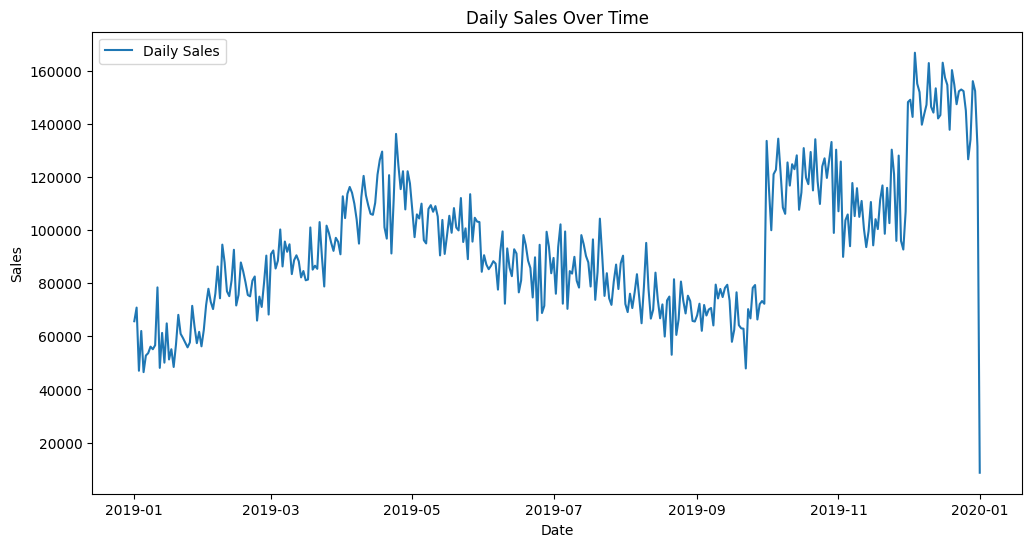

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales["sales"], label="Daily Sales")
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

#### Outlier detection and removal (IQR method)

In [4]:
Q1 = daily_sales['sales'].quantile(0.25)
Q3 = daily_sales['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (daily_sales['sales'] >= lower_bound) & (daily_sales['sales'] <= upper_bound)
outliers = daily_sales[~mask]
print("Outliers:\n", outliers)

daily_sales = daily_sales[mask].copy()
daily_sales.index = pd.to_datetime(daily_sales.index)


Outliers:
                 sales
date                 
2019-12-04  166727.69
2019-12-10  162832.74
2019-12-16  162970.61
2020-01-01    8670.29


#### Train-test split data

In [5]:
# Assuming daily_sales is a prepared series: index=DatetimeIndex (date), column 'sales'
y = daily_sales['sales'].astype(float)

# 80% train – 20% test
split_idx = int(len(y)*0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#### Fit SARIMA model on training set

In [6]:
sarima_model_m30 = sm.tsa.statespace.SARIMAX(
    y_train,
    order=(4,1,0),
    seasonal_order=(2,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model_m30.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                  289
Model:             SARIMAX(4, 1, 0)x(2, 1, [1], 30)   Log Likelihood               -2095.738
Date:                              Sun, 14 Sep 2025   AIC                           4207.476
Time:                                      15:47:52   BIC                           4233.619
Sample:                                  01-01-2019   HQIC                          4218.062
                                       - 10-16-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5641      0.098     -5.781      0.000      -0.755      -0.373
ar.L2         -0.45

#### Forecast with SARIMA and evaluate performance

In [7]:
forecast_m30 = sarima_model_m30.predict(start=len(y_train), 
                                        end=len(y_train)+len(y_test)-1, 
                                        dynamic=False)
mae = mean_absolute_error(y_test, forecast_m30)
rmse = np.sqrt(mean_squared_error(y_test, forecast_m30))
mape = np.mean(np.abs((y_test - forecast_m30) / y_test)) * 100

print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

MAE : 16521.6
RMSE: 19369.16
MAPE: 14.0 %


#### Plot forecast

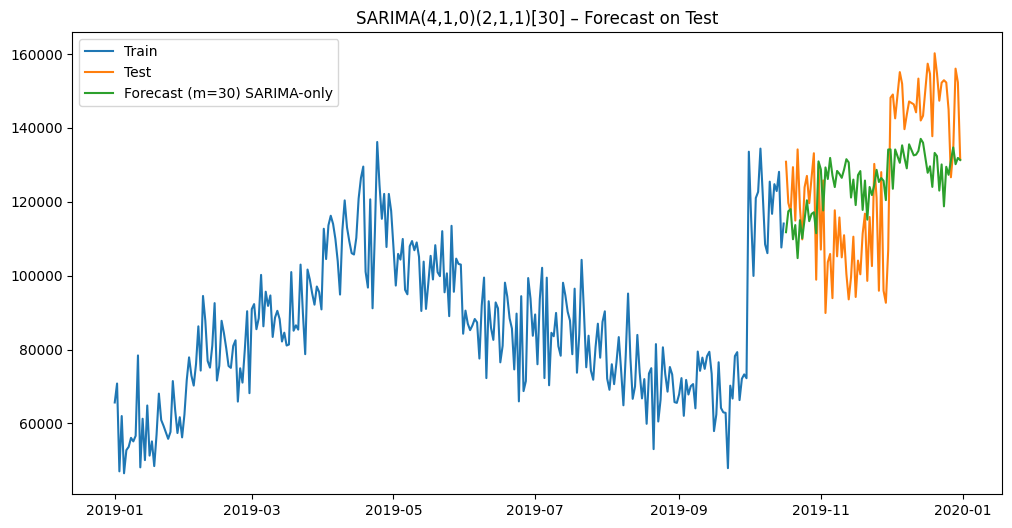

In [8]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train.values, label="Train")
plt.plot(y_test.index, y_test.values, label="Test")
plt.plot(y_test.index, forecast_m30, label="Forecast (m=30) SARIMA-only")
plt.title("SARIMA(4,1,0)(2,1,1)[30] – Forecast on Test")
plt.legend()
plt.show()

#### Analyze residuals (train and test)

Residual mean: -802.65


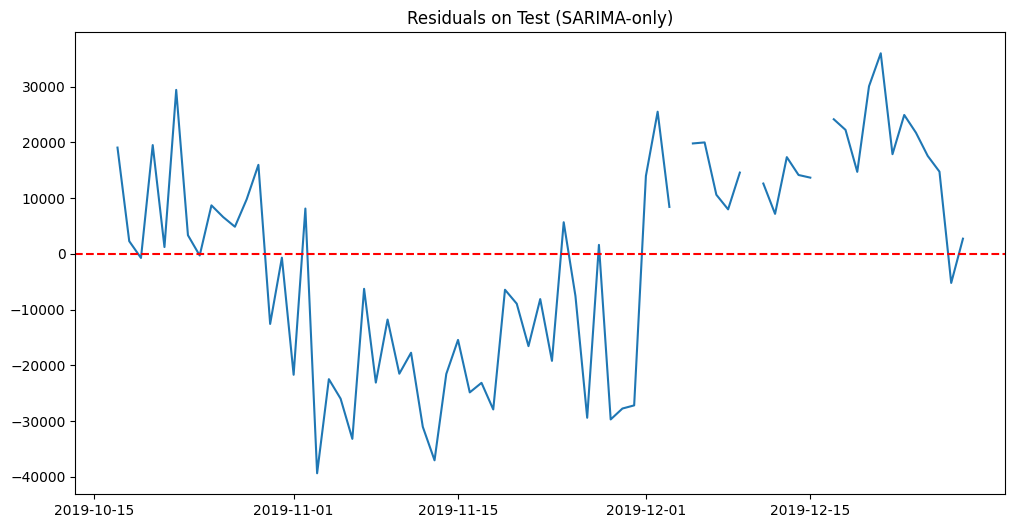

Resid train mean: -293.1187


In [9]:
# Residuals on Test
residuals_test = y_test - forecast_m30
print("Residual mean:", residuals_test.mean().round(2))
plt.figure(figsize=(12, 6))
plt.plot(residuals_test)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals on Test (SARIMA-only)")
plt.show()

# Residuals on train 
sarima_train_pred = sarima_model_m30.predict(start=y_train.index[0], end=y_train.index[-1])
sarima_train_pred = np.array(sarima_train_pred).astype(float)
resid_train = y_train.values - sarima_train_pred    # 1D numpy array
print("Resid train mean:", resid_train.mean().round(4))

#### Prepare residuals sequences for LSTM

In [10]:
def create_sequences(arr, look_back):
    X, y = [], []
    for i in range(len(arr) - look_back):
        X.append(arr[i:i+look_back])
        y.append(arr[i+look_back])
    return np.array(X), np.array(y)

look_back = 30   # bạn có thể thử 30/60/90
X_seq, y_seq = create_sequences(resid_train, look_back)
print("X_seq.shape:", X_seq.shape, "y_seq.shape:", y_seq.shape)

X_seq.shape: (259, 30) y_seq.shape: (259,)


#### Data Normalization

In [11]:
# Scale residuals 
scaler_X_resid = MinMaxScaler(feature_range=(-1, 1))
X_seq_scaled = scaler_X_resid.fit_transform(X_seq)

scaler_y_resid = MinMaxScaler(feature_range=(-1, 1))
y_seq_scaled = scaler_y_resid.fit_transform(y_seq.reshape(-1,1)).ravel()

X_seq_scaled = X_seq_scaled.reshape((X_seq_scaled.shape[0], X_seq_scaled.shape[1], 1))
y_seq_scaled_2d = y_seq_scaled.reshape(-1, 1)

#### Build and train LSTM model on residuals

In [12]:
def build_model(input_shape):
    m = Sequential()
    m.add(LSTM(100, input_shape=input_shape))
    m.add(Dropout(0.2))
    m.add(Dense(1))
    m.compile(loss='mean_squared_error', optimizer='adam')
    return m

model = build_model((X_seq_scaled.shape[1], X_seq_scaled.shape[2]))
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_seq_scaled, y_seq_scaled_2d, epochs=100, batch_size=32, verbose=1, shuffle=False, callbacks=[es])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0757
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0592
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0562
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0562
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0547
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0547
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0539
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0550
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0535
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0547
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0534
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0540
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0551
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0535
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0545
Epoch 16/100
9/9 ━━

#### Forecast residuals with LSTM and create Hybrid forcast

In [13]:
sarima_test_forecast = sarima_model_m30.get_forecast(steps=len(y_test)).predicted_mean.values
sarima_test_forecast = np.array(sarima_test_forecast).astype(float)

last_resid_history = resid_train[-look_back:].copy()
pred_resids = []
r_input = last_resid_history.copy()

for t in range(len(y_test)):
    X_in = r_input.reshape(1, -1)
    X_in_scaled = scaler_X_resid.transform(X_in)
    X_in_scaled = X_in_scaled.reshape((1, look_back, 1))
    pred_resid_scaled = model.predict(X_in_scaled, verbose=0)
    pred_resid = scaler_y_resid.inverse_transform(pred_resid_scaled)[0][0]
    pred_resids.append(pred_resid)
    r_input = np.concatenate([r_input[1:], np.array([pred_resid])])
pred_resids = np.array(pred_resids)
hybrid_forecast = sarima_test_forecast + pred_resids

#### Evaluate and compare SARIMA vs Hybrid

In [14]:
y_test_vals = y_test.values
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

mae_s, rmse_s, mape_s = metrics(y_test_vals, sarima_test_forecast)
mae_h, rmse_h, mape_h = metrics(y_test_vals, hybrid_forecast)

print(f"SARIMA      -> MAE: {mae_s:.4f}, RMSE: {rmse_s:.4f}, MAPE: {mape_s:.4f}")
print(f"Hybrid      -> MAE: {mae_h:.4f}, RMSE: {rmse_h:.4f}, MAPE: {mape_h:.4f}")

SARIMA      -> MAE: 16521.6001, RMSE: 19369.1570, MAPE: 13.8851
Hybrid      -> MAE: 16624.7660, RMSE: 19408.5828, MAPE: 13.9207


#### Plot Compare SARIMA vs Hybrid on Test

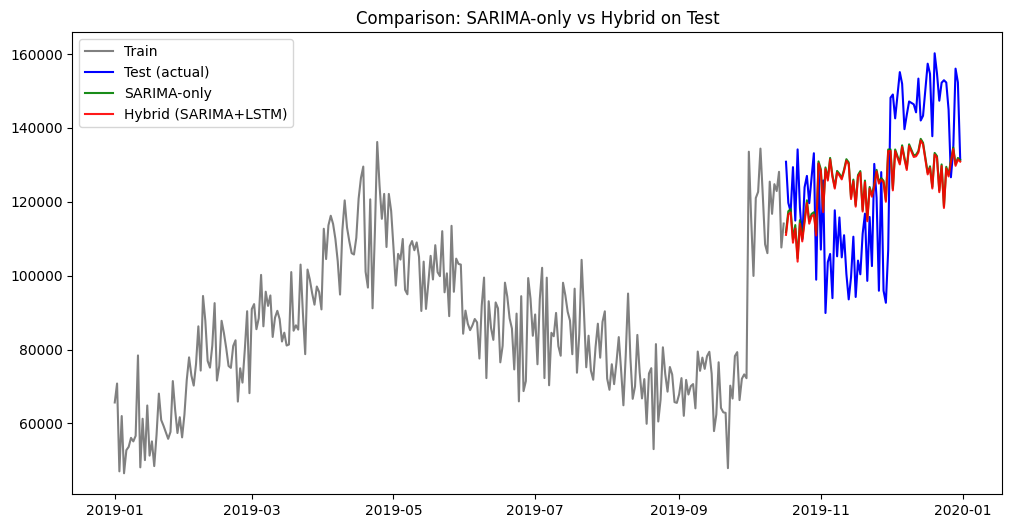

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train.values, label='Train', color='gray')
plt.plot(y_test.index, y_test_vals, label='Test (actual)', color='blue')
plt.plot(y_test.index, sarima_test_forecast, label='SARIMA-only', color='green', alpha=0.9)
plt.plot(y_test.index, hybrid_forecast, label='Hybrid (SARIMA+LSTM)', color='red', alpha=0.9)
plt.legend()
plt.title("Comparison: SARIMA-only vs Hybrid on Test")
plt.show()

#### Residual diagnostics (ACF, PACF, Ljung-Box)

<Figure size 1200x400 with 0 Axes>

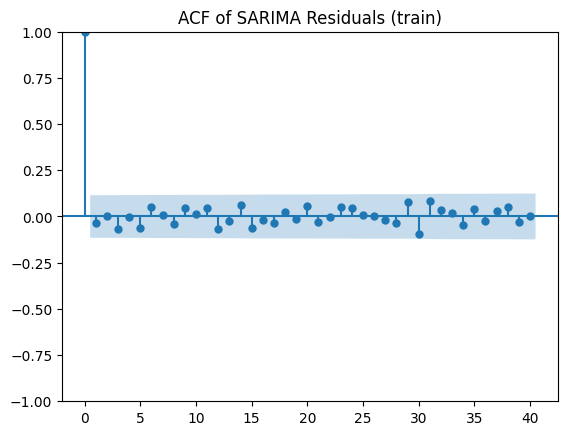

<Figure size 1200x400 with 0 Axes>

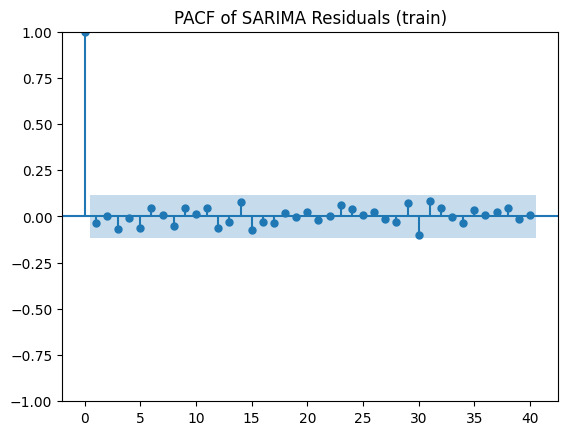

Ljung-Box test results:
      lb_stat  lb_pvalue
10   4.944623   0.894846
20  11.309018   0.937812
30  18.298203   0.953503


In [16]:
plt.figure(figsize=(12,4))
plot_acf(resid_train, lags=40, alpha=0.05)
plt.title("ACF of SARIMA Residuals (train)")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(resid_train, lags=40, alpha=0.05, method='ywm')
plt.title("PACF of SARIMA Residuals (train)")
plt.show()

lb = acorr_ljungbox(resid_train, lags=[10,20,30], return_df=True)
print("Ljung-Box test results:")
print(lb)

### Residual Diagnostics: ACF, PACF, and Ljung-Box

The plots of **ACF** and **PACF** for SARIMA residuals show that almost all lags fall within the confidence bounds.  
- This indicates **no significant autocorrelation** remaining in the residuals.  
- In other words, SARIMA has already captured the main time-dependent structure of the data.  

The **Ljung-Box test** further confirms this:  
- For lags 10, 20, and 30, the p-values are all very high (>> 0.05).  
- High p-values mean we **cannot reject the null hypothesis** that residuals are white noise.  

➡️ Together, these results demonstrate that the SARIMA residuals resemble **white noise**.  
This explains why the Hybrid SARIMA+LSTM model did not improve performance: there was no meaningful residual pattern left for LSTM to learn.


# Discussion

The Hybrid SARIMA + LSTM model was implemented with the expectation that:
- SARIMA would capture the **linear trend and seasonality**,  
- LSTM would learn the **nonlinear residual patterns**,  
- Combining them would reduce forecast errors compared to using each model individually.  

However, evaluation results showed that the **Hybrid model did not outperform SARIMA-only or LSTM-only**.  
- **Residual diagnostics (ACF, PACF, Ljung-Box test)** indicated that the SARIMA residuals resembled **white noise**.  
- This means that SARIMA had already captured most of the data’s structure (trend + seasonality), leaving little to no autocorrelation for the LSTM to learn.  
- As a result, the LSTM essentially tried to learn random noise, which **added variance** rather than improving accuracy.  

### Key takeaways:
- **Hybrid residual learning works best** when SARIMA leaves behind meaningful residual patterns with autocorrelation.  
- If residuals ≈ white noise, then **LSTM cannot add value**, and standalone models may perform better.  
- In our case, **LSTM autoregressive** alone achieved the best performance (lower MAPE than SARIMA and Hybrid).  

### Next steps:
- Consider using **LSTM Autoregressive** as the final model.  
- Alternatively, explore **ensemble averaging** between SARIMA and LSTM forecasts to reduce variance.  
- For more complex datasets, hybridization may still be valuable if residuals contain structured signals.  
